In [1]:
import pandas as pd

In [2]:
from sentence_transformers.readers import STSBenchmarkDataReader
from sentence_transformers import SentenceTransformer,  SentencesDataset, LoggingHandler

ModuleNotFoundError: No module named 'sentence_transformers'

In [4]:
import os

os.path.abspath(os.curdir)

'/Users/md/Downloads/qa'

In [26]:
sts_reader = STSBenchmarkDataReader('/Users/md/Downloads/qa/data/stsbenchmark')

len(sts_reader.get_examples("sts-test.csv"))

1379

In [31]:
def from_input_examples(examples, **kwargs):
    sentences1 = []
    sentences2 = []
    scores = []

    for example in examples:
        sentences1.append(example.texts[0])
        sentences2.append(example.texts[1])
        scores.append(example.label)
    return sentences1, sentences2, scores

In [34]:
sentences1,sentences2,scores=from_input_examples(sts_reader.get_examples("sts-test.csv"))

In [59]:
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from scipy.stats import pearsonr, spearmanr

class Sent():
    def __init__(self,sentences1,sentences2,scores,batch_size: int = 16, show_progress_bar: bool = False):

        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.scores = scores

        assert len(self.sentences1) == len(self.sentences2)
        assert len(self.sentences1) == len(self.scores)

        self.batch_size = batch_size
        self.show_progress_bar = show_progress_bar
    def run(self, model):
        embeddings1 = model.encode(self.sentences1, batch_size=self.batch_size, 
                                   show_progress_bar=self.show_progress_bar, convert_to_numpy=True)
        embeddings2 = model.encode(self.sentences2, batch_size=self.batch_size, 
                                   show_progress_bar=self.show_progress_bar, convert_to_numpy=True)
        labels = self.scores

        self.cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))
        #manhattan_distances = -paired_manhattan_distances(embeddings1, embeddings2)
        #euclidean_distances = -paired_euclidean_distances(embeddings1, embeddings2)
        #dot_products = [np.dot(emb1, emb2) for emb1, emb2 in zip(embeddings1, embeddings2)]


        self.eval_pearson_cosine, _ = pearsonr(labels, self.cosine_scores)
        self.eval_spearman_cosine, _ = spearmanr(labels, self.cosine_scores)

In [60]:
def get_examples(filename, max_examples=0):
    """
    filename specified which data split to use (train.csv, dev.csv, test.csv).
    """
    filepath = os.path.join(self.dataset_folder, filename)
    with gzip.open(filepath, 'rt', encoding='utf8') if filename.endswith('.gz') else open(filepath, encoding="utf-8") as fIn:
        data = csv.reader(fIn, delimiter=self.delimiter, quoting=self.quoting)
        examples = []
        for id, row in enumerate(data):
            score = float(row[self.score_col_idx])
            if self.normalize_scores:  # Normalize to a 0...1 value
                score = (score - self.min_score) / (self.max_score - self.min_score)

            s1 = row[self.s1_col_idx]
            s2 = row[self.s2_col_idx]
            examples.append(InputExample(guid=filename+str(id), texts=[s1, s2], label=score))

            if max_examples > 0 and len(examples) >= max_examples:
                break

    return examples

In [8]:
pd.read_csv('data/quora-IR-dataset/duplicate-mining/test_corpus.tsv',sep='\t', encoding="utf-8").head(50)

,qid,question
0,186351,"I am taking an year off to study in Resonance,..."
1,53489,"What's the origin of getting ""Shanghaied""?"
2,204694,What is the meaning of dream where everybody a...
3,400804,What are the most intellectually stimulating T...
4,266726,Is GeForce 940mx better than 940m?
5,16760,Why do people hate bodybuilders?
6,63297,How do I start a real estate fund?
7,338304,What are the qualities that are need to entrep...
8,438102,What are some tips on training a Belgian Malin...
9,89534,How can I make 1 dollar online?


In [5]:
import spacy

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
doc=nlp('she is good')

In [66]:
%%time
model1 = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
s1=Sent(sentences1,sentences2,scores)
s1.run(model1)
s1.cosine_scores
s1.eval_spearman_cosine

CPU times: user 1min 42s, sys: 1.73 s, total: 1min 44s
Wall time: 18.7 s


0.8516186502017491

In [65]:
%%time
model2 = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')
s2=Sent(sentences1,sentences2,scores)
s2.run(model2)
s2.cosine_scores
s2.eval_spearman_cosine

CPU times: user 4min 3s, sys: 3.7 s, total: 4min 7s
Wall time: 44.6 s


0.8543785752053276

In [77]:

df=pd.DataFrame([])
df['sentences1']=sentences1
df['sentences2']=sentences2
df['scores']=scores
df['dis']=s1.cosine_scores
df['rob']=s2.cosine_scores
df['diff']=df.apply(lambda x: abs(x['rob']-x['dis']), axis=1)
df['confident']=df.apply(lambda x: 'rob' if abs(x['rob']) > abs(x['dis']) else 'dis', axis=1)

In [79]:
df['select_better']=df.apply(lambda x: x['rob'] \
            if abs(x['rob'] - x['scores']) < abs(x['dis'] - x['scores']) else x['dis'], axis=1)

In [80]:
spearmanr(scores, df.select_better)

SpearmanrResult(correlation=0.9099423206948174, pvalue=0.0)

<AxesSubplot:ylabel='Frequency'>

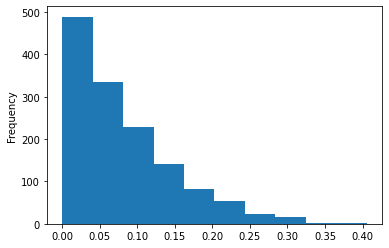

In [74]:
df['diff'].plot.hist()

In [78]:
df[df['diff']>0.25]

,sentences1,sentences2,scores,dis,rob,diff,confident
66,A woman is peeling shrimp.,A man is squeezing water.,0.04,-0.075067,0.230965,0.306031,rob
76,A boy is crawling into a dog house.,A boy is playing a wooden flute.,0.15,0.337788,0.032909,0.304878,dis
118,A woman is slicing ginger.,A person is holding two baby lorises.,0.00,0.169298,-0.236162,0.405460,rob
122,Someone touched the kitten chewing on a string.,Someone is cutting paper.,0.05,-0.040823,0.305194,0.346017,rob
203,A man is lifting weights.,A man is chopping egg plant.,0.05,0.328567,0.048930,0.279637,dis
217,A cat gets stuck on a moving ceiling fan.,A cat is swinging on a fan.,0.84,0.714705,0.452193,0.262512,dis
325,"A man sitting cross legged on the grass, with ...",Ocean liner close to coast with houses in the ...,0.00,-0.148636,0.116309,0.264945,dis
535,A woman is about to paint.,A boy is about to take a picture.,0.20,0.485699,0.234277,0.251422,dis
564,People are waiting for the fireworks to start.,Three people are waiting for the rain to stop.,0.24,0.489592,0.199899,0.289693,dis
653,It's pretty much up to you.,It's much better to ask.,0.00,0.533359,0.226955,0.306404,dis


In [20]:
sts_reader.get_examples("sts-test.csv")[0].texts

['A girl is styling her hair.', 'A girl is brushing her hair.']

In [4]:
pd.read_csv('./data/stsbenchmark/sts-test.csv').shape

ParserError: Error tokenizing data. C error: Expected 1 fields in line 99, saw 3
